# Proyek Klasifikasi Gambar: [Malaria Cell Detection]
- **Nama:** [Rasendra Akbar Satyatama]
- **Email:** [mc004d5y1124@student.devacademy.id]
- **ID Dicoding:** [MC004D5Y1124]

Notebook ini berisi proses analisis dan klasifikasi gambar untuk mendeteksi penyakit malaria dari citra sel darah menggunakan pendekatan Convolutional Neural Network (CNN). Model CNN dirancang untuk membedakan antara dua kelas utama, yaitu Parasitized (terinfeksi malaria) dan Uninfected (tidak terinfeksi), berdasarkan pola visual yang tampak pada gambar mikroskopis sel darah.

## Import Semua Packages/Library yang Digunakan

In [35]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflowjs as tfjs
from keras.models import load_model

## Data Preparation

### Data Loading

In [2]:
def import_gambar(dir):
    images = []
    labels = []

    for category in os.listdir(dir):
        category_path = os.path.join(dir, category)
        for filename in tqdm(os.listdir(category_path), desc=f"Loading {category}"):
            if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            image_path = os.path.join(category_path, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Gagal memuat gambar: {image_path}")
                continue

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (128, 128))
            images.append(image)
            labels.append(category)

    images = np.array(images, dtype='float32')
    return images, labels

##### Jika terdapat gambar yang tidak bisa dimuat maka akan dilewati

In [3]:
data_dir = 'data/cell_images'
X, y = import_gambar(data_dir)

Loading Uninfected: 100%|██████████| 13780/13780 [00:57<00:00, 238.63it/s]


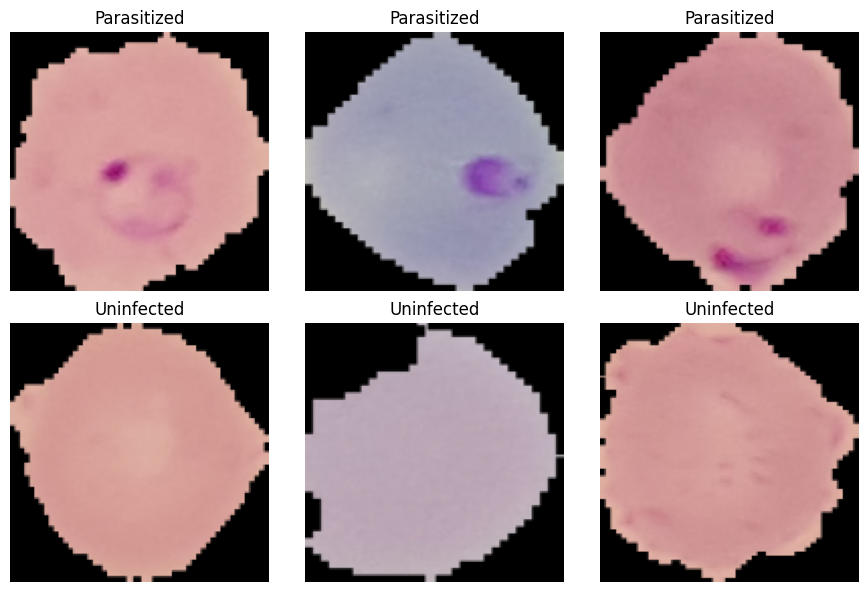

In [4]:
def tampilkan_contoh_gambar_tertentu(images, labels, kelas_unik, jumlah_per_kelas=3):
    plt.figure(figsize=(jumlah_per_kelas * 3, len(kelas_unik) * 3))

    for idx, kelas in enumerate(kelas_unik):
        indeks_kelas = [i for i, label in enumerate(labels) if label == kelas]

        contoh_indeks = [
            indeks_kelas[0],
            indeks_kelas[len(indeks_kelas) // 2],
            indeks_kelas[-1]
        ]

        for j, indeks in enumerate(contoh_indeks):
            i = idx * jumlah_per_kelas + j
            plt.subplot(len(kelas_unik), jumlah_per_kelas, i + 1)
            plt.imshow(images[indeks].astype('uint8'))
            plt.title(f"{kelas}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

kelas_unik = sorted(set(y))
tampilkan_contoh_gambar_tertentu(X, y, kelas_unik, jumlah_per_kelas=3)

In [5]:
distribusi = pd.Series(y).value_counts()

print("Distribusi jumlah gambar per kelas:")
print(distribusi)

Distribusi jumlah gambar per kelas:
Parasitized    13779
Uninfected     13779
Name: count, dtype: int64


### Data Preprocessing

#### Split Dataset 
- 80:10:10 Dalam skema ini, 80% dari data digunakan untuk pelatihan, 10% untuk validasi, dan 10% untuk pengujian.

In [6]:
X = X / 255.0

encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Karena X_temp sekarang 20%, maka split 50:50 untuk dapatkan 10% + 10%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

## Modelling

In [ ]:
cnn_model = Sequential()
cnn_model.add(Conv2D(16,(3,3),activation='relu',input_shape=(128,128,3)))
cnn_model.add(MaxPool2D(2,2))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(32,(3,3),activation='relu'))
cnn_model.add(MaxPool2D(2,2))
cnn_model.add(Dropout(0.3))

cnn_model.add(Conv2D(64,(3,3),activation='relu'))
cnn_model.add(MaxPool2D(2,2))
cnn_model.add(Dropout(0.3))

cnn_model.add(Flatten())
cnn_model.add(Dense(64,activation='relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(1,activation='sigmoid'))

In [9]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 32)        0

Model CNN yang dibangun terdiri dari beberapa lapisan konvolusi dan pooling, diikuti oleh lapisan dense yang diakhiri dengan fungsi aktivasi sigmoid untuk klasifikasi biner antara sel darah yang Parasitized (terinfeksi malaria) dan Uninfected (tidak terinfeksi). Proses pelatihan dilakukan pada dataset citra berukuran 128x128 piksel dengan tiga saluran warna (RGB). Dengan memanfaatkan dropout untuk menghindari overfitting

In [10]:
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [11]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20


1378/1378 [==============================] - 59s 42ms/step - loss: 0.4439 - accuracy: 0.7825 - val_loss: 0.1968 - val_accuracy: 0.9314 - lr: 0.0010
Epoch 2/20
1378/1378 [==============================] - 56s 40ms/step - loss: 0.2060 - accuracy: 0.9380 - val_loss: 0.1629 - val_accuracy: 0.9438 - lr: 0.0010
Epoch 3/20
1378/1378 [==============================] - 57s 41ms/step - loss: 0.1794 - accuracy: 0.9483 - val_loss: 0.1542 - val_accuracy: 0.9521 - lr: 0.0010
Epoch 4/20
1378/1378 [==============================] - 57s 41ms/step - loss: 0.1645 - accuracy: 0.9507 - val_loss: 0.1541 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 5/20
1378/1378 [==============================] - 56s 41ms/step - loss: 0.1535 - accuracy: 0.9526 - val_loss: 0.1530 - val_accuracy: 0.9459 - lr: 0.0010
Epoch 6/20
1378/1378 [==============================] - 59s 42ms/step - loss: 0.1444 - accuracy: 0.9537 - val_loss: 0.1493 - val_accuracy: 0.9536 - lr: 0.0010
Epoch 7/20
1378/1378 [======================

## Evaluasi dan Visualisasi

In [13]:
train_loss, train_acc = cnn_model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = cnn_model.evaluate(X_val, y_val, verbose=0)

print(f"Akurasi Train: {train_acc:.4f}")
print(f"Akurasi Validation: {val_acc:.4f}")

Akurasi Train: 0.9736
Akurasi Validation: 0.9572


In [14]:
test_loss, test_acc = cnn_model.evaluate(X_test, y_test, verbose=0)

print(f"Akurasi Test: {test_acc:.4f}")

Akurasi Test: 0.9561


Model Convolutional Neural Network (CNN) yang dikembangkan untuk mendeteksi infeksi malaria dari citra sel darah menunjukkan performa yang sangat baik. Dengan akurasi pelatihan sebesar 97.36%, model mampu mengenali pola visual dari gambar secara efektif selama proses pembelajaran. Pada data validasi, model mempertahankan kinerja yang stabil dengan akurasi 95.72%, menunjukkan bahwa model tidak mengalami overfitting secara signifikan. Akurasi pada data pengujian sebesar 95.61% juga mengindikasikan bahwa model mampu melakukan generalisasi dengan baik terhadap data baru yang belum pernah dilihat sebelumnya. Secara keseluruhan, hasil ini menunjukkan bahwa arsitektur CNN yang digunakan efektif dalam mengklasifikasikan citra sel darah sebagai Parasitized atau Uninfected, serta memiliki potensi untuk diaplikasikan dalam sistem pendukung diagnosis malaria secara otomatis.

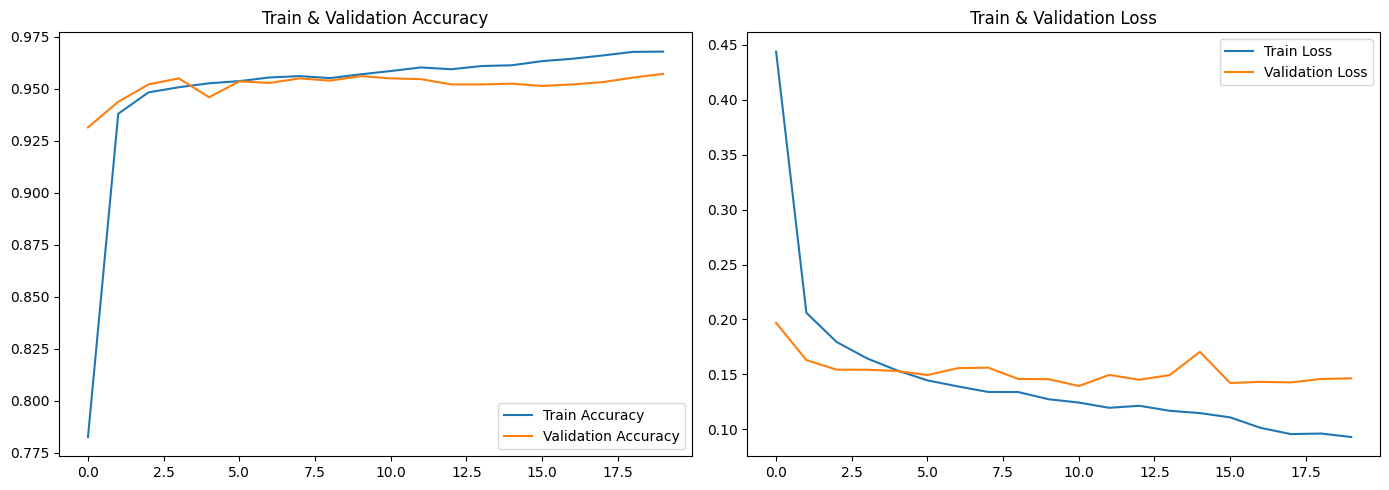

In [15]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Train & Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Train & Validation Loss')

    plt.tight_layout()
    plt.show()

plot_history(history)

87/87 [==============================] - 1s 15ms/step


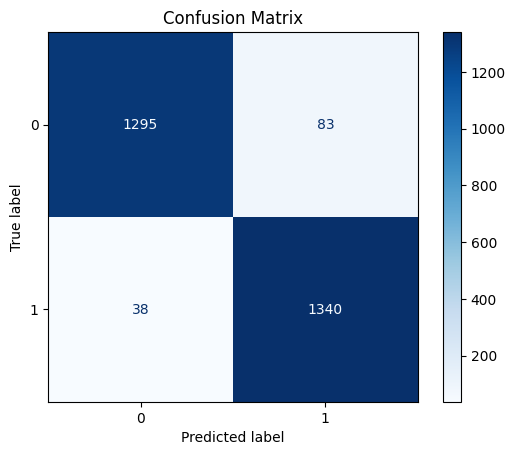

In [21]:
y_pred_prob = cnn_model.predict(X_test)

if y_pred_prob.shape[1] == 1:
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    y_true = y_test
else:
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [22]:
cnn_model.save('malaria_model.h5')

## Konversi Model

In [23]:
cnn_model.export('saved_model')

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='conv2d_input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2988685632016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2988685633168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2988685632400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2988685632592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2988685635088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2988685634896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2988685637200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2988685637008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2988685636432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2988685636624: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
tflite_model = converter.convert()

import os
os.makedirs('tflite', exist_ok=True)
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

class_names = ['Parasitized', 'Uninfected']
with open('tflite/label.txt', 'w') as f:
    for label in class_names:
        f.write(f"{label}\n")

INFO:tensorflow:Assets written to: C:\Users\Rasen\AppData\Local\Temp\tmpzey6dynd\assets


INFO:tensorflow:Assets written to: C:\Users\Rasen\AppData\Local\Temp\tmpzey6dynd\assets


In [25]:
tfjs.converters.save_keras_model(cnn_model, 'tfjs_model')

## Inference (Optional)

87/87 [==============================] - 1s 14ms/step


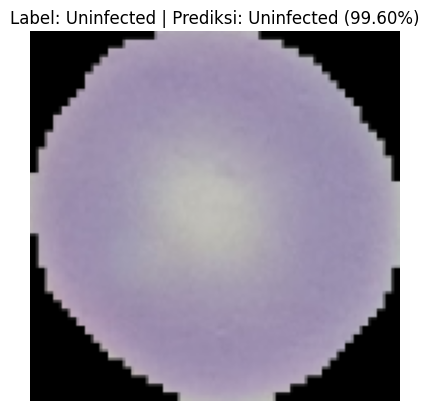

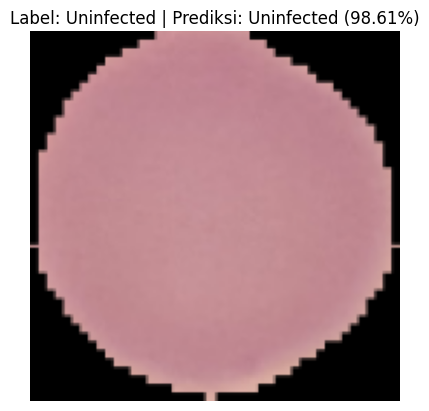

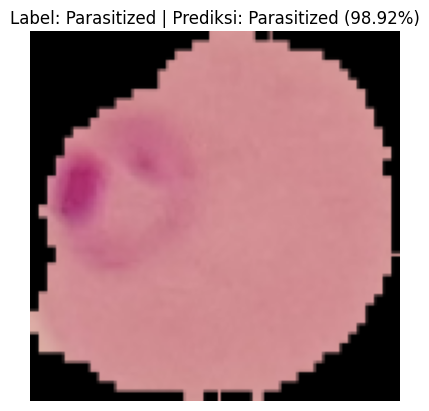

In [34]:
model_test = load_model('malaria_model.h5')
class_names = encoder.classes_

y_pred_prob = model_test.predict(X_test)

y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = y_test

def show_prediction(img, true_label, pred_label, prob):
    plt.imshow(img)
    plt.title(f"Label: {true_label} | Prediksi: {pred_label} ({prob:.2%})")
    plt.axis('off')
    plt.show()

random_indices = np.random.choice(len(X_test), size=3, replace=False)

for i in random_indices:
    img = X_test[i]
    true_label = class_names[y_true[i]]
    pred_class_idx = y_pred[i]
    pred_label = class_names[pred_class_idx]
    prob = y_pred_prob[i][0] if pred_class_idx == 1 else 1 - y_pred_prob[i][0]
    
    show_prediction(img, true_label, pred_label, prob)